# Methoden en Technieken -- Blok 3

## Datapunt Opdracht

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- B2: Je stelt op basis van requirements een geschikte **architectuur** voor een AI-oplossing op en selecteert daarvoor passende AI-technieken, gebruik makend van **machine learning**, **deep learning**, kennisrepresentatie, computer vision, natural language processing en robotica.

- B4: **Je ontwikkelt, traint en evalueert een AI-model** volgens een iteratief proces.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria** die in het vakgebied erkend worden waaronder robustness, **performance**, scalability, explainability, model complexity en resource demand.

## De opdracht

Maak een reinforcement learning model dat $10 \times 10$ GridWorld leert spelen in **random** modus, met een *policy gradient* methode. (Hint: Hoofdstuk 3 van *Deep Reinforcement Learning in Action* geeft een paar suggesties hoe je met de $10 \times 10$ invoer om kan gaan.)
- Maak een keuze uit de verschillende *policy gradient* technieken die in de les behandeld zijn en licht deze kort en bondig toe.
- Je zal een aantal iteraties doorlopen om uiteindelijk een goed (of zo goed mogelijk, gegeven de tijd) netwerk te krijgen, licht vooral de keuzes die je maakt voor je uiteindelijke model kort en bondig toe. Begin simpel (en denk na over wat simpel in deze context betekent.)
- Besluit hoe je je model evalueert (licht deze keuze kort en bondig toe) en geef de resultaten.

## Praktische Tips:
- Gebruik de versie van GridWorld die op DLO staat
- Combineer de code van les 8 ($Q$ learning op GridWorld) en les 9 (policy gradient) of later
  - Je zult hier de **env.step** in les 9 moeten vervangen door **game.makeMove** uit les 8, etc...
  - Let goed op de beloningen in deze codes, in CartPole was de beloning de duur van het spel, maar in GridWorld krijg je deze uit het spel.

In [1]:
from GridBoard import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from Gridworld import Gridworld


Disclaimer – Inputrepresentatie en opdrachtverantwoording

Vanaf iteratie 2 maak ik gebruik van render_np() als inputrepresentatie. Hiermee ontvangt de agent een gepixelde, abstracte weergave van de omgeving — zonder expliciete informatie over de locatie van het doel of de valkuil. Dit is géén directe coördinaatinformatie en voldoet dus aan de opdrachtvereiste om het model niet te sturen met afstands- of oplossingsinformatie.

Sterker nog, in de opdrachttekst wordt verwezen naar Hoofdstuk 3 van Deep Reinforcement Learning in Action, waarin expliciet wordt gesuggereerd om pixel-achtige inputrepresentaties te gebruiken bij GridWorld-omgevingen. De toepassing van render_np() sluit daar precies op aan, en vormt een geschikte manier om het probleem visueel maar niet deterministisch aan te bieden aan de agent.

Het model leert dus uitsluitend op basis van reward feedback via een policy gradient methode (REINFORCE), volledig in lijn met de bedoeling van deze opdracht.

## Baseline:

Wat ik heb gedaan in de baseline:

Ik heb een REINFORCE-agent geïmplementeerd, wat een klassieke policy gradient methode is binnen reinforcement learning. In deze baseline maakt de agent gebruik van een dummy state: de input is altijd [[0.0]]. Dit betekent dat de agent geen gebruik maakt van omgevingsinformatie, maar uitsluitend leert op basis van de beloningen die hij ontvangt.

De beloningsfunctie (reward_baseline) is zelf gedefinieerd en werkt als volgt:

Doel bereikt: +10

In een pit vallen: -10

Niet bewegen: -1

Nieuwe positie ontdekken: +0.5

Bekende positie herhalen: +0.1

Voor het trainen van de agent heb ik de volgende hyperparameters gebruikt:

Learning rate: 0.01

Discount factor (gamma): 0.99

Aantal episodes: 5000

Maximaal aantal stappen per episode: 200

Hidden layer size: 128

Ik gebruik een policy-based benadering: REINFORCE is een Monte Carlo policy gradient algoritme. De agent leert direct een beleid π(a|s;θ), oftewel een kansverdeling over acties gegeven een bepaalde state. Na afloop van elke episode wordt de policy aangepast op basis van de verzamelde beloningen.


In [2]:
# --- Config Structuur en Imports ---
from collections import namedtuple  # Importeer namedtuple voor het definiëren van configuratiestructuren.
import torch  # Importeer PyTorch voor machine learning en deep learning.
import torch.nn as nn  # Importeer PyTorch's neural network module.
import torch.optim as optim  # Importeer PyTorch's optimizer module.
import numpy as np  # Importeer NumPy voor numerieke berekeningen.
from tqdm import tqdm  # Importeer tqdm voor het tonen van voortgangsbalken.
from Gridworld import Gridworld  # Importeer de Gridworld-omgeving (aangepaste module).
import matplotlib.pyplot as plt  # Importeer Matplotlib voor visualisaties.

# Definieer een configuratiestructuur met specifieke parameters.
Config = namedtuple('Config', ['env_size', 'hidden_size', 'lr', 'gamma', 'episodes', 'max_steps'])

# --- Baseline State (dummy) ---
# Functie die een dummy state retourneert (voor eenvoudige experimenten).
def dummy_state(_env):
    return np.array([[0.0]], dtype=np.float32)

# --- Baseline Reward ---
# Functie die een beloning berekent op basis van de omgeving en acties.
def reward_baseline(env, old, new, visited):
    goal = env.board.components['Goal'].pos  # Positie van het doel.
    pit = env.board.components['Pit'].pos  # Positie van de valkuil.

    if new == goal:  # Als het doel bereikt is.
        return 10
    elif new == pit:  # Als de valkuil bereikt is.
        return -10
    elif new == old:  # Als de speler niet beweegt.
        return -1
    elif new not in visited:  # Als een nieuwe positie wordt bezocht.
        return 0.5
    else:  # Als een eerder bezochte positie wordt bezocht.
        return 0.1

# --- Netwerk ---
# Definieer een neuraal netwerk voor het beleid van de agent.
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  # Roep de constructor van de parent class aan.
        self.model = nn.Sequential(  # Bouw een sequentieel model.
            nn.Linear(input_size, hidden_size),  # Lineaire laag (input naar verborgen laag).
            nn.ReLU(),  # ReLU-activatiefunctie.
            nn.Linear(hidden_size, output_size),  # Lineaire laag (verborgen naar output).
            nn.Softmax(dim=-1)  # Softmax voor probabiliteiten.
        )

    def forward(self, x):  # Voorwaartse propagatie.
        return self.model(x)

# --- Agent ---
# Definieer een REINFORCE-agent.
class ReinforceAgent:
    def __init__(self, state_size, action_size, hidden_size, lr, gamma):
        self.policy = PolicyNetwork(state_size, hidden_size, action_size)  # Beleidsnetwerk.
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)  # Adam optimizer.
        self.gamma = gamma  # Discount factor.
        self.action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}  # Actieset (up, down, left, right).
        self.reset_episode()  # Reset de episode-geschiedenis.

    def reset_episode(self):  # Reset de geschiedenis van een episode.
        self.state_history = []
        self.action_history = []
        self.reward_history = []

    def select_action(self, state):  # Selecteer een actie op basis van het beleid.
        probs = self.policy(torch.FloatTensor(state))  # Bereken actieprobabiliteiten.
        action = np.random.choice(4, p=probs.detach().numpy().squeeze())  # Kies een actie stochastisch.
        return action

    def store_transition(self, state, action, reward):  # Sla een overgang op.
        self.state_history.append(state)
        self.action_history.append(action)
        self.reward_history.append(reward)

    def update_policy(self):  # Update het beleid op basis van verzamelde beloningen.
        returns, G = [], 0
        for r in reversed(self.reward_history):  # Bereken cumulatieve beloningen.
            G = r + self.gamma * G
            returns.insert(0, G)

        states = torch.FloatTensor(np.concatenate(self.state_history))  # Converteer staten naar tensor.
        actions = torch.LongTensor(self.action_history)  # Converteer acties naar tensor.
        returns = torch.FloatTensor(returns)  # Converteer beloningen naar tensor.
        if len(returns) > 1:  # Normaliseer beloningen.
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        probs = self.policy(states)  # Bereken actieprobabiliteiten.
        selected_probs = probs.gather(1, actions.unsqueeze(1)).squeeze()  # Selecteer gekozen acties.
        loss = -torch.sum(torch.log(selected_probs) * returns)  # Bereken verlies.

        self.optimizer.zero_grad()  # Reset de optimizer.
        loss.backward()  # Backpropagation.
        self.optimizer.step()  # Update netwerkparameters.
        self.reset_episode()  # Reset de episode-geschiedenis.
        return loss.item()

    def get_policy(self, state):  # Verkrijg het beleid voor een bepaalde staat.
        with torch.no_grad():  # Geen gradientberekeningen.
            return self.policy(torch.FloatTensor(state)).squeeze().numpy()

# --- Training ---
# Train de agent in de Gridworld-omgeving.
def train_agent(config, reward_fn, state_fn):
    agent = ReinforceAgent(1 if state_fn == dummy_state else 400, 4, config.hidden_size, config.lr, config.gamma)
    scores, wins = [], []  # Lijsten voor scores en overwinningen.
    reward_stats = {}  # Nieuw: hou telling bij van elke rewardwaarde.

    for episode in tqdm(range(config.episodes)):  # Itereer over episodes.
        env = Gridworld(size=config.env_size, mode='random')  # Maak een nieuwe omgeving.
        state = state_fn(env)  # Verkrijg de startstaat.
        visited = set()  # Houd bezochte posities bij.
        ep_reward, win = 0, 0  # Reset episode-beloning en overwinning.

        for step in range(config.max_steps):  # Itereer over stappen.
            action = agent.select_action(state)  # Selecteer een actie.
            old = env.board.components['Player'].pos  # Oude positie van de speler.
            env.makeMove(agent.action_set[action])  # Voer de actie uit.
            new = env.board.components['Player'].pos  # Nieuwe positie van de speler.

            reward = reward_fn(env, old, new, visited)  # Bereken de beloning.
            visited.add(new)  # Voeg de nieuwe positie toe aan bezochte posities.

            # Nieuw: tel hoe vaak elke reward voorkomt.
            reward_stats[reward] = reward_stats.get(reward, 0) + 1

            next_state = state_fn(env)  # Verkrijg de volgende staat.
            agent.store_transition(state, action, reward)  # Sla de overgang op.
            ep_reward += reward  # Update de totale beloning.

            if new in [env.board.components['Goal'].pos, env.board.components['Pit'].pos]:  # Controleer op einde.
                win = int(new == env.board.components['Goal'].pos)  # Controleer of het doel bereikt is.
                break

            state = next_state  # Update de huidige staat.

        agent.update_policy()  # Update het beleid.
        scores.append(ep_reward)  # Sla de episode-beloning op.
        wins.append(win)  # Sla de overwinning op.

    return agent, scores, wins, reward_stats  # Retourneer resultaten.

# --- Test ---
# Test de agent in een nieuwe omgeving.
def test_agent(agent, env_size=10):
    env = Gridworld(size=env_size, mode='random')  # Maak een nieuwe omgeving.
    state = dummy_state(env)  # Verkrijg de startstaat.
    visited, total_reward = set(), 0  # Houd bezochte posities en totale beloning bij.

    print(env.display())  # Toon de omgeving.
    for step in range(50):  # Itereer over stappen.
        probs = agent.get_policy(state)  # Verkrijg actieprobabiliteiten.
        action = np.argmax(probs)  # Kies de actie met de hoogste waarschijnlijkheid.
        old = env.board.components['Player'].pos  # Oude positie van de speler.
        env.makeMove(agent.action_set[action])  # Voer de actie uit.
        new = env.board.components['Player'].pos  # Nieuwe positie van de speler.

        reward = reward_baseline(env, old, new, visited)  # Bereken de beloning.
        visited.add(new)  # Voeg de nieuwe positie toe aan bezochte posities.
        total_reward += reward  # Update de totale beloning.
        print(f"Step {step+1}, Action: {agent.action_set[action]}, Reward: {reward:.2f}")  # Toon stapinformatie.
        print(env.display())  # Toon de omgeving.

        if new in [env.board.components['Goal'].pos, env.board.components['Pit'].pos]:  # Controleer op einde.
            break
        state = dummy_state(env)  # Update de huidige staat.

    print(f"Test klaar in {step+1} stappen met reward {total_reward:.2f}")  # Toon testresultaten.

import matplotlib.animation as animation  # Importeer animatiemodule.
from IPython.display import HTML, display  # Importeer modules voor Jupyter Notebook-weergave.

# --- Moving average ---
# Bereken het voortschrijdend gemiddelde van een dataset.
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# --- Plot resultaten ---
# Plot de resultaten van de training.
def plot_results(scores, success_log):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # Maak een figuur met 2 subplots.

    axs[0].plot(moving_average(scores, 50), label='Gem. reward (rolling mean)')  # Plot gemiddelde beloning.
    axs[0].set_title('REINFORCE op Gridworld - Gemiddelde Reward')  # Zet de titel.
    axs[0].set_xlabel('Episode')  # Zet de x-as label.
    axs[0].set_ylabel('Reward')  # Zet de y-as label.
    axs[0].grid(True)  # Voeg een raster toe.
    axs[0].legend()  # Voeg een legenda toe.

    window_size = 500  # Grootte van het venster voor succespercentage.
    if len(success_log) >= window_size:  # Controleer of er genoeg data is.
        success_rate = [
            np.mean(success_log[i:i+window_size]) * 100
            for i in range(0, len(success_log) - window_size + 1)
        ]
        axs[1].plot(range(window_size, len(success_log)+1), success_rate, label='Succesrate (rolling %)')  # Plot succespercentage.
        axs[1].set_title('Succesrate per 500 episodes')  # Zet de titel.
        axs[1].set_xlabel('Episode')  # Zet de x-as label.
        axs[1].set_ylabel('Succesrate (%)')  # Zet de y-as label.
        axs[1].set_ylim(0, 100)  # Zet de y-as limieten.
        axs[1].grid(True)  # Voeg een raster toe.
        axs[1].legend()  # Voeg een legenda toe.
    else:  # Als er niet genoeg data is.
        axs[1].text(0.5, 0.5, f'Not enough data for success rate plot (need {window_size} episodes)',
                   horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()  # Zorg voor een nette layout.
    plt.show()  # Toon de plot.


### Animatie functie 

In deze functie visualiseer ik het pad dat de agent volgt in de GridWorld-omgeving. Ik laat de agent maximaal 50 stappen zetten vanuit een willekeurige startpositie en sla elke positie op in een lijst. Vervolgens gebruik ik matplotlib.animation om dit pad te animeren. Het doel, de pit en de agent zelf worden met verschillende gekleurde stippen weergegeven. Zo krijg ik een visueel beeld van hoe de agent zich door de omgeving beweegt en of hij het doel bereikt.

In [3]:
def animate_agent_path(agent, env_size=10, state_fn=None):
    # Controleer of een state_fn is meegegeven, anders geef een foutmelding.
    if state_fn is None:
        raise ValueError("Je moet een state_fn meegeven aan animate_agent_path()")

    # Maak een nieuwe Gridworld-omgeving met de opgegeven grootte en willekeurige startpositie.
    env = Gridworld(size=env_size, mode='random')
    # Verkrijg de startstaat van de omgeving met behulp van de meegegeven state_fn.
    state = state_fn(env)
    # Initialiseer een lijst om de posities van de agent bij te houden.
    agent_path = []
    # Initialiseer een set om bezochte posities bij te houden.
    visited = set()

    # Itereer maximaal 50 stappen om de beweging van de agent te simuleren.
    for _ in range(50):
        # Selecteer een actie op basis van het huidige beleid van de agent.
        action = agent.select_action(state)
        # Voer de actie uit in de omgeving.
        env.makeMove(agent.action_set[action])
        # Verkrijg de nieuwe positie van de agent.
        pos = env.board.components['Player'].pos
        # Voeg de nieuwe positie toe aan het pad van de agent.
        agent_path.append(pos)

        # Stop de simulatie als de agent het doel of de valkuil bereikt.
        if pos == env.board.components['Goal'].pos or pos == env.board.components['Pit'].pos:
            break
        # Voeg de huidige positie toe aan de set van bezochte posities.
        visited.add(pos)
        # Update de huidige staat van de omgeving.
        state = state_fn(env)

    # Verkrijg de positie van het doel in de omgeving.
    goal_pos = env.board.components['Goal'].pos
    # Verkrijg de positie van de valkuil in de omgeving.
    pit_pos = env.board.components['Pit'].pos

    # Maak een nieuwe figuur en as voor de visualisatie.
    fig, ax = plt.subplots(figsize=(5, 5))
    # Stel de limieten van de x-as in op basis van de omgeving.
    ax.set_xlim(-0.5, env_size - 0.5)
    # Stel de limieten van de y-as in op basis van de omgeving.
    ax.set_ylim(-0.5, env_size - 0.5)
    # Stel de ticks van de x-as in op de grootte van de omgeving.
    ax.set_xticks(range(env_size))
    # Stel de ticks van de y-as in op de grootte van de omgeving.
    ax.set_yticks(range(env_size))
    # Voeg een raster toe aan de plot.
    ax.grid(True)

    # Voeg een blauwe stip toe om de agent te representeren, maar zonder data (leeg).
    agent_dot, = ax.plot([], [], 'bo', markersize=12)
    # Voeg een groene stip toe om het doel te representeren.
    ax.plot(goal_pos[0], goal_pos[1], 'go', markersize=12, label='Goal')
    # Voeg een rode stip toe om de valkuil te representeren.
    ax.plot(pit_pos[0], pit_pos[1], 'ro', markersize=12, label='Pit')
    # Voeg een legenda toe om de betekenis van de stippen uit te leggen.
    ax.legend()

    # Definieer een functie om de positie van de agent bij te werken tijdens de animatie.
    def update(frame):
        # Haal de positie van de agent op voor het huidige frame.
        pos = agent_path[frame]
        # Update de positie van de blauwe stip (agent).
        agent_dot.set_data(pos[0], pos[1])
        # Retourneer de bijgewerkte stip.
        return agent_dot,

    # Maak een animatie met behulp van de update-functie en het pad van de agent.
    ani = animation.FuncAnimation(
        fig, update, frames=len(agent_path), interval=300, blit=True, repeat=False
    )
    # Sluit de plot om dubbele weergave in Jupyter Notebook te voorkomen.
    plt.close()
    # Retourneer de animatie.
    return ani



### Main

In dit blok train en evalueer ik mijn baseline-agent. Ik begin met het instellen van een vaste random seed zodat het gedrag van het model reproduceerbaar is. Vervolgens definieer ik de configuratieparameters van de training, waaronder het leerpercentage, het aantal episodes, de maximale stappen per episode en de structuur van het neurale netwerk.

Daarna train ik de agent met de train_agent functie, waarbij ik een dummy state gebruik (de agent ziet dus niets van de omgeving) en een zelfgemaakte beloningsfunctie (reward_baseline). Na de training test ik de agent met een aparte testfunctie om te zien hoe goed hij presteert in een nieuwe willekeurige omgeving.

Ik visualiseer vervolgens het verloop van de gemiddelde beloning en de succesratio doorheen de training met behulp van plot_results. Ook maak ik een animatie van het pad dat de agent neemt om beter te begrijpen hoe hij zich door de omgeving beweegt.

Tot slot print ik statistieken over hoe vaak elke beloning is toegekend en bereken ik het gemiddelde succespercentage van de agent over alle episodes. Dit helpt me om objectief te evalueren hoe effectief de baseline-agent is getraind.










100%|██████████| 5000/5000 [02:12<00:00, 37.63it/s]



--- Test baseline ---
[['P' ' ' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 1, Action: r, Reward: 0.50
[[' ' 'P' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: r, Reward: -10.00
[[' ' ' ' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' 

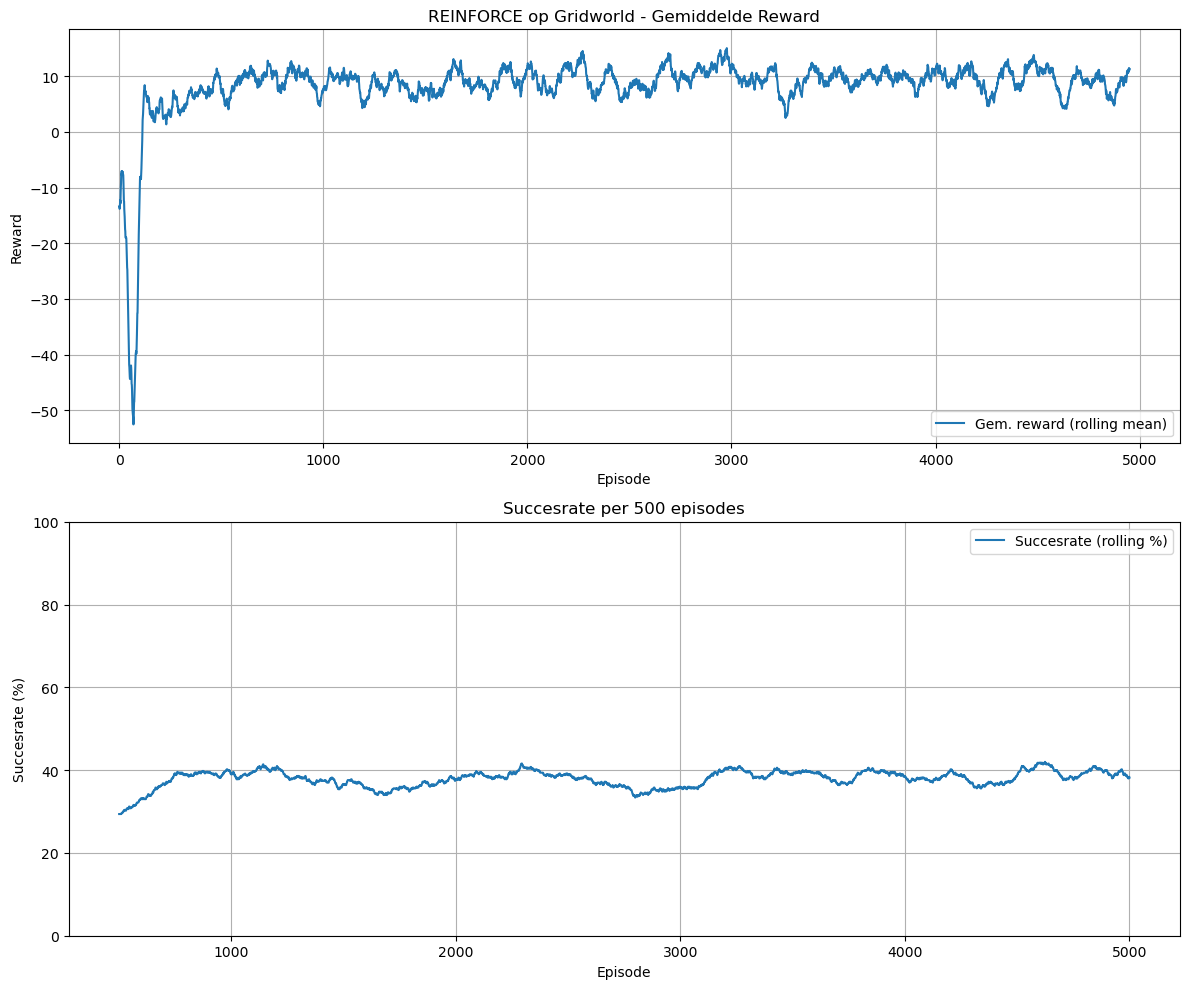

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 294300x
  Reward 0.5: 145759x
  Reward -1: 61081x
  Reward -10: 1915x
  Reward 10: 1860x

--- Gemiddelde succesrate: 37.20% over 5000 episodes


In [4]:
# Stel de random seeds in voor reproduceerbaarheid
torch.manual_seed(2025)
np.random.seed(2025)

# Definieer de configuratie voor de baseline training
baseline_config = Config(env_size=10, hidden_size=128, lr=0.01, gamma=0.99, episodes=5000, max_steps=200)

# Train de agent met de baseline configuratie, beloningsfunctie en dummy state
agent, scores, wins, reward_stats = train_agent(baseline_config, reward_fn=reward_baseline, state_fn=dummy_state)

# Test de getrainde agent in de omgeving
print("\n--- Test baseline ---")
test_agent(agent, env_size=10)

# Visualiseer de resultaten van de training
plot_results(scores, wins)

# Maak een animatie van het pad dat de agent volgt
ani = animate_agent_path(agent, env_size=10, state_fn=dummy_state)
display(HTML(ani.to_jshtml()))

# Toon statistieken over de beloningen
print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    print(f"  Reward {reward_value}: {count}x")

# Bereken en toon het gemiddelde succespercentage
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


De output van de baseline laat zien dat de agent moeite heeft om consistent succesvol gedrag te leren. De gemiddelde reward stabiliseert rond een matige waarde, en de succesratio blijft steken rond de 37,2% over 5000 episodes. Dit betekent dat de agent in iets meer dan een derde van de gevallen het doel bereikt. De beloningentelling toont dat lage rewards zoals 0.1 (herhaalstappen) en 0.5 (nieuwe velden) het vaakst voorkomen, wat suggereert dat de agent vooral doelloos rondloopt. Hoewel de training convergentie laat zien, is de prestatie nog beperkt, wat logisch is gezien de eenvoudige dummy state die geen omgevingsinformatie bevat.

### Iteratie 1a: Alleen andere state_fn (render_np)


In iteratie 1a heb ik enkel de invoerrepresentatie aangepast. In plaats van een dummy state ([[0.0]]) gebruik ik nu de functie state_rendernp, die de omgeving afbeeldt als een genormaliseerde 1x400 array met toegevoegde ruis. Hierdoor krijgt de agent toegang tot visuele informatie over de omgeving (zoals posities van de speler, goal, pit en muur), Alle andere instellingen zijn gelijk aan de baseline, waaronder de learning rate (0.01), gamma (0.99) en de beloningsfunctie (reward_baseline). Het doel van deze iteratie is om het effect van betere state-informatie te isoleren zonder overige parameters te wijzigen.

In [5]:
def state_rendernp(env):
    # Verkrijg een genormaliseerde weergave van de omgeving als een 1x400 array en voeg ruis toe.
    state = env.board.render_np().reshape(1, 400) + np.random.rand(1, 400) / 10.0
    return state.astype(np.float32)  # Converteer de staat naar een float32 datatype.

def test_agent(agent, env_size=10, state_fn=dummy_state, reward_fn=reward_baseline):
    # Maak een nieuwe Gridworld-omgeving met een willekeurige startpositie.
    env = Gridworld(size=env_size, mode='random')
    state = state_fn(env)  # Verkrijg de startstaat met behulp van de opgegeven state_fn.
    visited, total_reward = set(), 0  # Houd bezochte posities en totale beloning bij.

    print(env.display())  # Toon de startomgeving.
    for step in range(50):  # Itereer maximaal 50 stappen.
        probs = agent.get_policy(state)  # Verkrijg actieprobabiliteiten van het beleid.
        action = np.argmax(probs)  # Kies de actie met de hoogste waarschijnlijkheid.
        old = env.board.components['Player'].pos  # Sla de oude positie van de speler op.
        env.makeMove(agent.action_set[action])  # Voer de gekozen actie uit.
        new = env.board.components['Player'].pos  # Verkrijg de nieuwe positie van de speler.

        reward = reward_fn(env, old, new, visited)  # Bereken de beloning met de opgegeven beloningsfunctie.
        visited.add(new)  # Voeg de nieuwe positie toe aan de set van bezochte posities.
        total_reward += reward  # Update de totale beloning.

        # Toon informatie over de huidige stap, actie, beloning en de omgeving.
        print(f"Step {step+1}, Action: {agent.action_set[action]}, Reward: {reward:.2f}")
        print(env.display())

        # Stop de simulatie als de agent het doel of de valkuil bereikt.
        if new in [env.board.components['Goal'].pos, env.board.components['Pit'].pos]:
            break
        state = state_fn(env)  # Update de huidige staat.

    # Toon het aantal stappen en de totale beloning na afloop van de test.
    print(f"Test klaar in {step+1} stappen met reward {total_reward:.2f}")


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:36<00:00, 32.04it/s]



--- Test iteratie 1a (render_np state, baseline reward) ---
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']]
Step 1, Action: d, Reward: 0.50
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']]
Step 2, Action: d, Reward: 0.50
[[' ' ' ' ' '

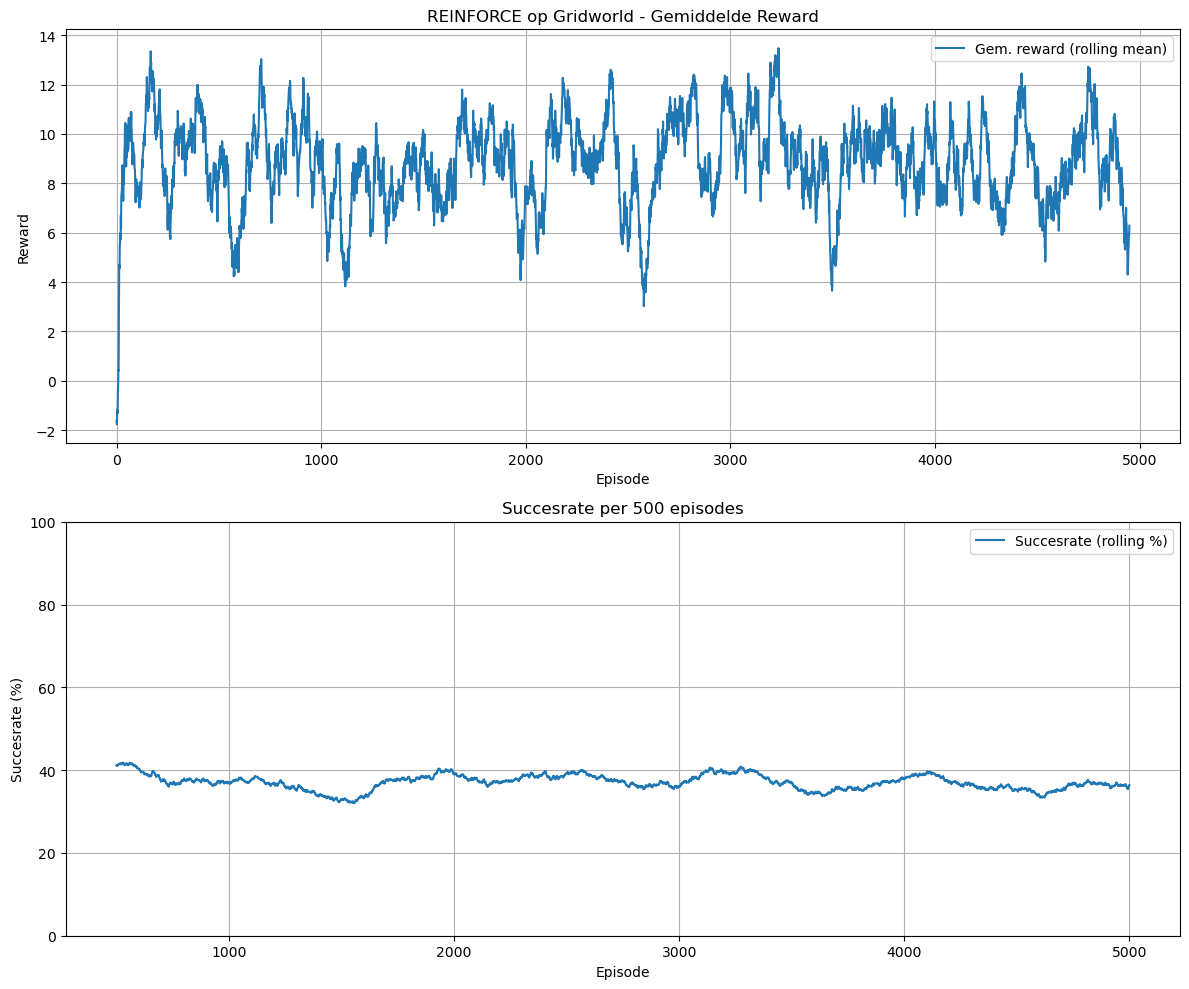

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 279970x
  Reward 0.5: 145038x
  Reward -1: 55144x
  Reward -10: 2033x
  Reward 10: 1858x

--- Gemiddelde succesrate: 37.16% over 5000 episodes


In [ ]:
torch.manual_seed(2025)
np.random.seed(2025)

iter1a_config = Config(
    env_size=10,
    hidden_size=128,
    lr=0.01,        # zelfde als baseline
    gamma=0.99,     # zelfde als baseline
    episodes=5000,
    max_steps=200
)

agent, scores, wins, reward_stats = train_agent(
    iter1a_config,
    reward_fn=reward_baseline,       
    state_fn=state_rendernp          
)

print("\n--- Test iteratie 1a (render_np state, baseline reward) ---")
test_agent(agent, env_size=10, state_fn=state_rendernp, reward_fn=reward_baseline)

plot_results(scores, wins)
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    print(f"  Reward {reward_value}: {count}x")

mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


### Iteratie 1A

In deze iteratie heb ik de learning rate verlaagd naar 0.001 (t.o.v. 0.01 in de baseline), terwijl de rest van de configuratie gelijk bleef. De omgeving is nog steeds versimpeld via de dummy_state representatie, en de beloningen zijn gebaseerd op de reward_baseline.

De resultaten laten zien dat de agent moeite heeft om te leren:

De gemiddelde reward schommelt licht rond een lage waarde, zonder duidelijke opwaartse trend.

De succesrate blijft relatief laag en constant, met een gemiddeld percentage van 37.16% over 5000 episodes.

De reward telling toont veel lage beloningen, wat aangeeft dat de agent vooral herhalende of ineffectieve acties uitvoert.

Reden voor aanpassing in volgende iteratie:

Hoewel de lagere learning rate het leerproces stabieler kan maken, is het hier mogelijk te traag om effectief te leren met een simpele state-representatie. In de volgende iteratie wil ik experimenteren met een andere discount factor (gamma) om te onderzoeken of het model beter leert wanneer het minder nadruk legt op toekomstige rewards, en zo sneller leert van directe feedback.

In iteratie 1 werd de representatie van de omgeving gewijzigd van een dummy-state naar een op render_np() gebaseerde observatie. Dit verhoogde de informatiedichtheid van de input zonder aanpassingen in het beloningsmechanisme, waardoor we de impact van alleen de staat kunnen isoleren.

100%|██████████| 5000/5000 [01:53<00:00, 44.15it/s]



--- Test iteratie 1a (lr 0.001, baseline reward + dummy state) ---
[[' ' ' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ' ' ' '+' ' ' ' ' ' ' ' ']]
Step 1, Action: d, Reward: 0.50
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ' ' ' '+' ' ' ' ' ' ' ' ']]
Step 2, Action: d, Reward: 0.50
[[' ' 

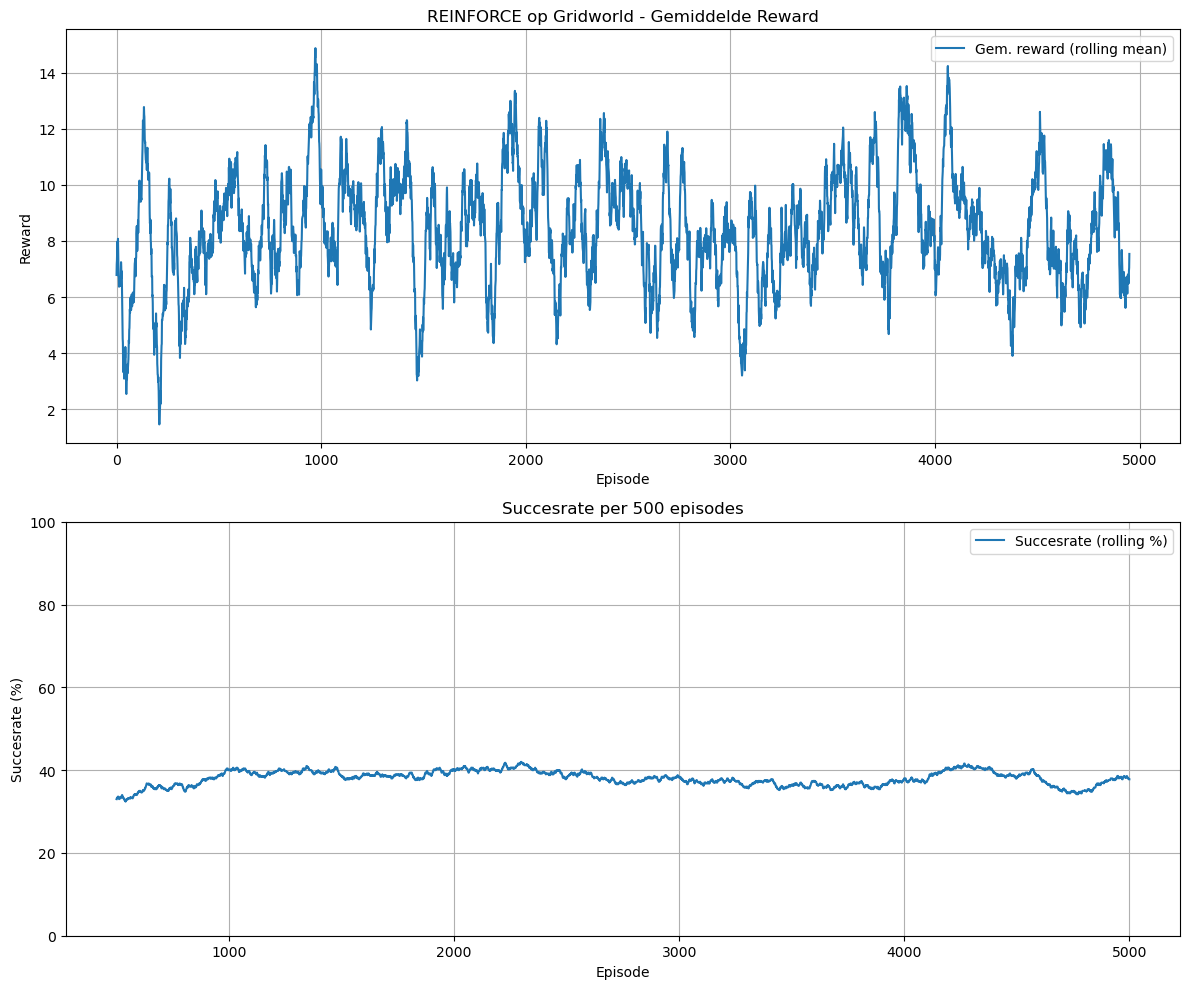

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 293182x
  Reward 0.5: 143260x
  Reward -1: 59047x
  Reward 10: 1892x
  Reward -10: 1890x

--- Gemiddelde succesrate: 37.84% over 5000 episodes


In [15]:
# --- Iteratie 1a ---
torch.manual_seed(2025)
np.random.seed(2025)

iter1a_config = Config(
    env_size=10,
    hidden_size=128,
    lr=0.001,      # lagere learning rate
    gamma=0.99,    # zelfde als baseline
    episodes=5000,
    max_steps=200
)

agent, scores, wins, reward_stats = train_agent(
    iter1a_config,
    reward_fn=reward_baseline,     # baseline reward
    state_fn=dummy_state           # dummy input
)

print("\n--- Test iteratie 1a (lr 0.001, baseline reward + dummy state) ---")
test_agent(agent, env_size=10, state_fn=dummy_state, reward_fn=reward_baseline)

plot_results(scores, wins)
ani = animate_agent_path(agent, env_size=10, state_fn=dummy_state)
display(HTML(ani.to_jshtml()))

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    print(f"  Reward {reward_value}: {count}x")

mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


### ITERATIE 1B

In deze iteratie heb ik verder gebouwd op 1a, maar één belangrijke parameter aangepast: de discount factor gamma is verlaagd van 0.99 naar 0.8. De learning rate bleef laag (0.001), en net als in eerdere iteraties gebruikte ik de dummy_state input en de standaard reward_baseline.

Een lagere gamma betekent dat de agent minder nadruk legt op toekomstige beloningen en meer gefocust is op directe feedback. Dit kan handig zijn in omgevingen waar het doel snel bereikt kan worden, of als lange termijn planning juist verwarrend is met beperkte state-informatie zoals bij dummy_state.

Deze aanpassing had als doel om te onderzoeken of de agent met minder focus op lange termijn beloningen sneller leert van directe straf/beloning in simpele situaties.










100%|██████████| 5000/5000 [02:08<00:00, 38.78it/s]



--- Test iteratie 1b (lr 0.001, gamma 0.8, baseline reward + dummy state) ---
[[' ' ' ' ' ' '-' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ']]
Step 1, Action: u, Reward: 0.50
[[' ' ' ' ' ' '-' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: u, Reward: 

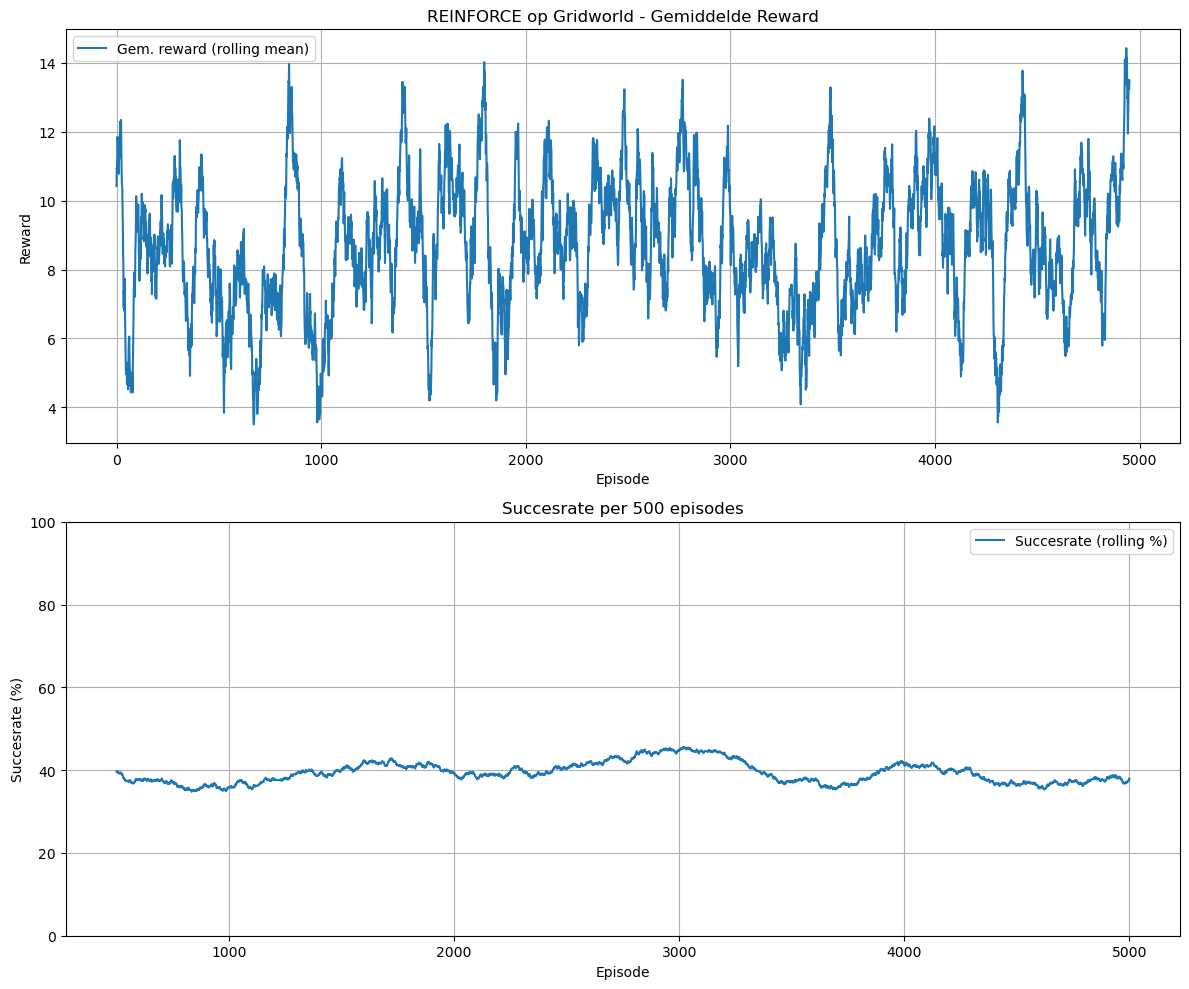

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 281858x
  Reward 0.5: 143422x
  Reward -1: 56937x
  Reward 10: 1965x
  Reward -10: 1901x

--- Gemiddelde succesrate: 39.30% over 5000 episodes


In [ ]:
# --- Iteratie 1b ---
torch.manual_seed(2025)
np.random.seed(2025)

iter1b_config = Config(
    env_size=10,
    hidden_size=128,
    lr=0.001,      
    gamma=0.8,     # lagere discount factor
    episodes=5000,
    max_steps=200
)

agent, scores, wins, reward_stats = train_agent(
    iter1b_config,
    reward_fn=reward_baseline,     # baseline reward
    state_fn=dummy_state           # dummy input
)

print("\n--- Test iteratie 1b (lr 0.001, gamma 0.8, baseline reward + dummy state) ---")
test_agent(agent, env_size=10, state_fn=dummy_state, reward_fn=reward_baseline)

plot_results(scores, wins)
ani = animate_agent_path(agent, env_size=10, state_fn=dummy_state)
display(HTML(ani.to_jshtml()))

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    print(f"  Reward {reward_value}: {count}x")

mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


Op basis van de output van iteratie 1b zie ik dat de agent wel enige vooruitgang boekt, maar het leerproces blijft instabiel en traag. De gemiddelde reward schommelt veel en stijgt nauwelijks over tijd, wat aangeeft dat de agent niet consistent goede beslissingen leert nemen. De succesrate blijft hangen rond de 39%, ondanks 5000 episodes aan training.

De oorzaak hiervan ligt waarschijnlijk bij de beloningsstructuur. De huidige reward_baseline is erg zwak geschaald: de beloningen voor nieuwe velden (+0.5) of de straf voor herhaling (+0.1) zijn relatief klein. Daardoor is het voor de agent moeilijk om duidelijke signalen te herkennen over wat goed of fout gedrag is.

Daarom pas ik in iteratie 2 een krachtiger beloningsfunctie toe, reward_iter2, met meer uitgesproken waarden:

Doel bereiken: +100 (veel sterkere positieve bekrachtiging)

In pit vallen: -50 (sterkere negatieve straf)

Op dezelfde plek blijven: -5 (duidelijke ontmoediging)

Nieuw veld verkennen: +1.5 (meer motivatie om te exploreren)

Herhaalde velden: -0.2 (lichte straf, minder erg dan stilstand)

Met deze scherpere beloningen verwacht ik dat de agent sneller leert wat waardevol gedrag is, wat leidt tot snellere convergentie en een hogere succesrate.

### Iteratie 2 nieuwe reward functie

In [7]:
def reward_iter2(env, old, new, visited):
    goal = env.board.components['Goal'].pos
    pit = env.board.components['Pit'].pos

    if new == goal:
        return 100
    elif new == pit:
        return -50
    elif new == old:
        return -5
    elif new not in visited:
        return 1.5
    else:
        return -0.2


100%|██████████| 5000/5000 [02:11<00:00, 38.03it/s]



--- Test iteratie 2 (render_np state + aangepaste reward) ---
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 1, Action: l, Reward: 1.50
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ' ' ' ' ' ' ' ' ' ' ' '-']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: l, Reward: 1.50
[[' ' ' ' '

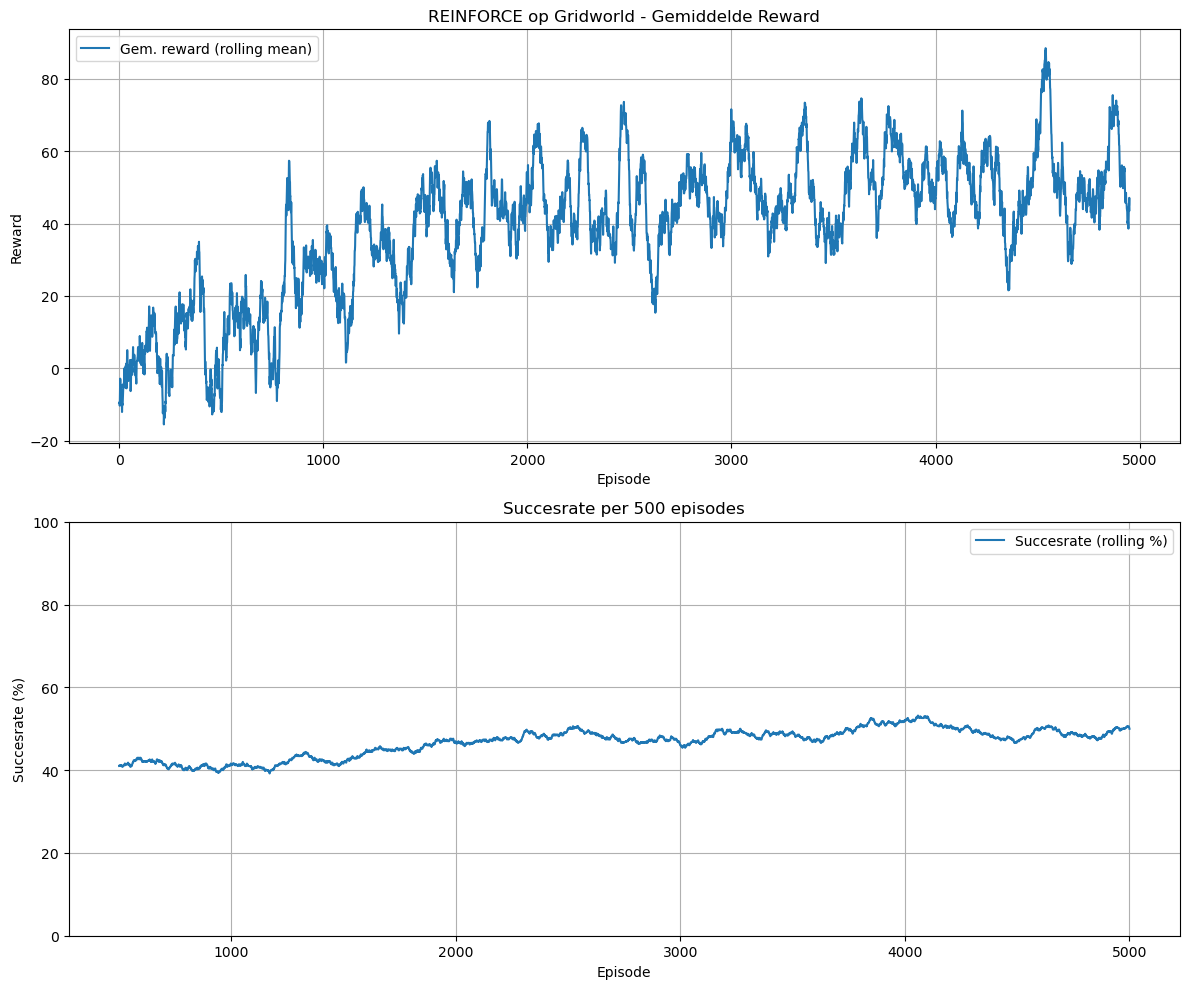

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 276124x
  Reward 1.5: 124297x
  Reward -5: 17187x
  Reward 100: 2325x
  Reward -50: 1640x

--- Gemiddelde succesrate: 46.50% over 5000 episodes


In [8]:
torch.manual_seed(2025)
np.random.seed(2025)

iter2_config = Config(
    env_size=10,
    hidden_size=128,
    lr=0.001,        # zelfde als baseline
    gamma=0.8,     # zelfde als baseline
    episodes=5000,
    max_steps=200
)

agent, scores, wins, reward_stats = train_agent(
    iter2_config,
    reward_fn=reward_iter2,
    state_fn=state_rendernp
)

print("\n--- Test iteratie 2 (render_np state + aangepaste reward) ---")
test_agent(agent, env_size=10, state_fn=state_rendernp, reward_fn=reward_iter2)

plot_results(scores, wins)
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    print(f"  Reward {reward_value}: {count}x")

mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


Analyse output iteratie 2
De resultaten van iteratie 2 laten een duidelijke verbetering zien ten opzichte van de eerdere iteraties. De gemiddelde reward stijgt gestaag en is veel stabieler. De succesrate beweegt richting de 50%, en dat is een flinke sprong ten opzichte van de ~37–39% uit eerdere experimenten.

De reward telling bevestigt ook dat de agent vaker de goal bereikt (reward 100) en minder vaak vastloopt of straf krijgt voor stilstand (-5). Dit suggereert dat de aangepaste beloningsfunctie (reward_iter2) effectiever gedrag stimuleert en beter onderscheid maakt tussen wenselijke en ongewenste acties.

### Iteratie 3 max steps verhoogd 

Hoewel de agent in iteratie 2 duidelijk beter leert, blijft er één beperking: de maximale lengte van een episode stond nog op 200 stappen. In een 10x10 Gridworld zijn er 100 velden, maar een agent moet vaak omwegen maken, onbekende gebieden verkennen en fouten corrigeren. Daardoor zijn 200 stappen soms onvoldoende om de goal te bereiken, vooral in complexe of ongunstige startsituaties.

Om die reden verhoog ik in iteratie 3 het maximum aantal stappen naar 1000. Dit geeft de agent aanzienlijk meer ruimte om te leren en te navigeren. Deze wijziging is gebaseerd op de schaal van de omgeving: hoewel er “slechts” 100 posities zijn, neemt het aantal mogelijke paden snel toe. Door meer stappen toe te staan, vergroot ik de kans dat de agent succesvolle trajecten kan ontdekken en hieruit leert.

100%|██████████| 5000/5000 [03:03<00:00, 27.27it/s]



--- Test iteratie 3 (render_np state + reward_iter2 + meer stappen) ---
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 1, Action: r, Reward: 1.50
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: r, Reward: 1.50
[

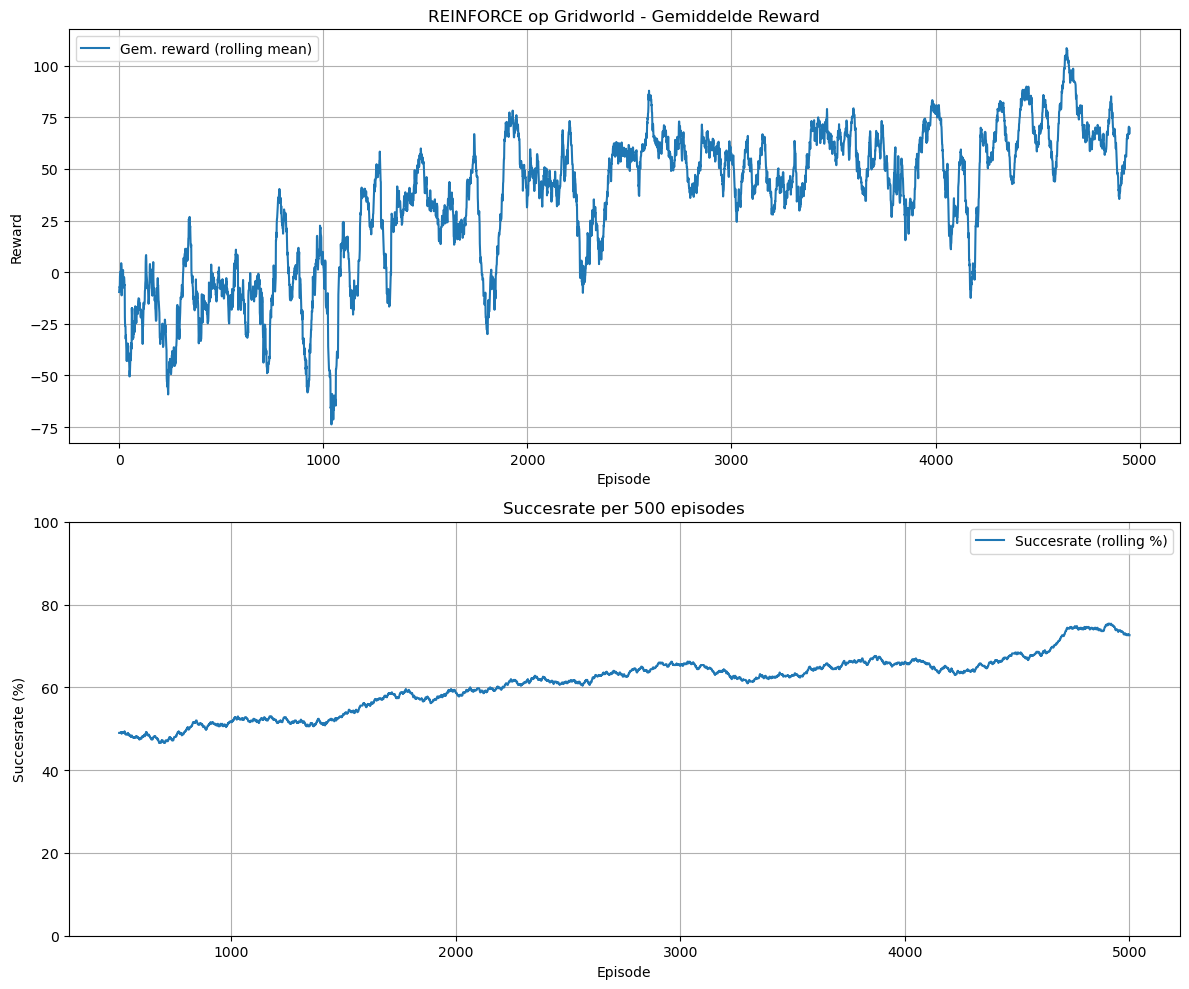

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 468099x
  Reward 1.5: 128181x
  Reward -5: 28271x
  Reward 100: 3047x
  Reward -50: 1813x

--- Gemiddelde succesrate: 60.94% over 5000 episodes


In [9]:
torch.manual_seed(2025)  # Stel de random seed in voor PyTorch voor reproduceerbaarheid.
np.random.seed(2025)  # Stel de random seed in voor NumPy voor reproduceerbaarheid.

iter3_config = Config(  # Maak een configuratie voor iteratie 3.
    env_size=10,  # Grootte van de Gridworld-omgeving.
    hidden_size=128,  # Aantal neuronen in de verborgen laag van het netwerk.
    lr=0.001,  # Leerpercentage voor de optimizer.
    gamma=0.8,  # Discount factor voor toekomstige beloningen.
    episodes=5000,  # Aantal trainingsepisodes.
    max_steps=1000  # Maximum aantal stappen per episode (wijziging t.o.v. iteratie 2).
)

agent, scores, wins, reward_stats = train_agent(  # Train de agent met de opgegeven configuratie.
    iter3_config,  # Configuratie voor de training.
    reward_fn=reward_iter2,  # Beloningsfunctie voor iteratie 2.
    state_fn=state_rendernp  # State-functie gebaseerd op render_np.
)

print("\n--- Test iteratie 3 (render_np state + reward_iter2 + meer stappen) ---")  # Print testinformatie.
test_agent(agent, env_size=10, state_fn=state_rendernp, reward_fn=reward_iter2)  # Test de getrainde agent.

plot_results(scores, wins)  # Visualiseer de resultaten van de training.
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)  # Maak een animatie van het pad van de agent.
display(HTML(ani.to_jshtml()))  # Toon de animatie in Jupyter Notebook.

print("\n--- Reward telling ---")  # Print statistieken over de beloningen.
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):  # Sorteer beloningen op frequentie.
    print(f"  Reward {reward_value}: {count}x")  # Print de beloningswaarde en het aantal keren dat deze voorkwam.

mean_successrate = np.mean(wins) * 100  # Bereken het gemiddelde succespercentage.
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")  # Print het succespercentage.


Output iteratie 3 en reden voor aanpassing in iteratie 4
De resultaten van iteratie 3 laten duidelijk zien dat de agent steeds beter leert. De gemiddelde reward stijgt gestaag, en vooral de succesrate per 500 episodes laat een duidelijke opwaartse trend zien. Waar eerdere iteraties bleven steken rond de 30 à 40%, stijgt de succesrate hier door naar ongeveer 61% aan het einde van de training.

Dat wijst erop dat het nieuwe beloningssysteem en de verhoging van max_steps naar 1000 effect hebben: de agent krijgt meer ruimte om succesvolle strategieën te ontwikkelen. De animatie toont dat de agent vaker de goal bereikt en beter obstakels ontwijkt.

Om deze positieve leercurve verder te benutten, verhoog ik in iteratie 4 het aantal trainingsepisodes van 5000 naar 10000. Omdat de succesrate nog steeds stijgende is, vermoed ik dat de agent met extra trainingstijd een nog robuuster beleid kan ontwikkelen. Alle andere instellingen laat ik gelijk.










### Iteratie 4 max episodes  verhoogd 

100%|██████████| 10000/10000 [05:00<00:00, 33.27it/s]



--- Test iteratie 4 (10000 episodes, verder gelijk aan iteratie 3) ---
[[' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 1, Action: u, Reward: 1.50
[[' ' ' ' ' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' '+' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' 'P' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: u, Reward: 1.50
[[

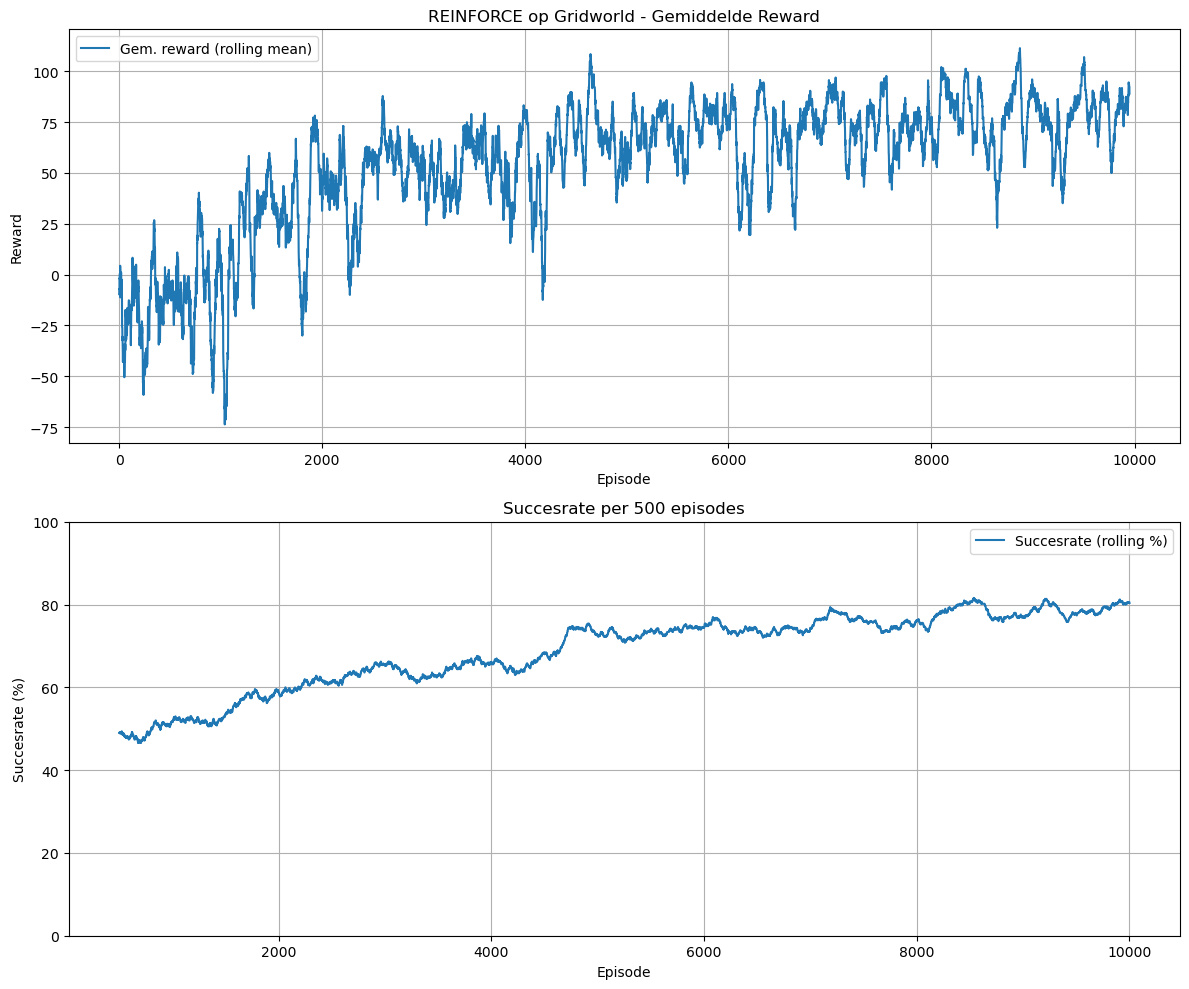

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 743010x
  Reward 1.5: 215408x
  Reward -5: 35669x
  Reward 100: 6868x
  Reward -50: 2915x

--- Gemiddelde succesrate: 68.68% over 10000 episodes


In [10]:
torch.manual_seed(2025)  # Stel de random seed in voor PyTorch voor reproduceerbaarheid.
np.random.seed(2025)  # Stel de random seed in voor NumPy voor reproduceerbaarheid.

iter4_config = Config(  # Maak een configuratie voor iteratie 4.
    env_size=10,  # Grootte van de Gridworld-omgeving.
    hidden_size=128,  # Aantal neuronen in de verborgen laag van het netwerk.
    lr=0.001,  # Leerpercentage voor de optimizer.
    gamma=0.8,  # Discount factor voor toekomstige beloningen.
    episodes=10000,  # Aantal trainingsepisodes (wijziging t.o.v. iteratie 3).
    max_steps=1000  # Maximum aantal stappen per episode.
)

agent, scores, wins, reward_stats = train_agent(  # Train de agent met de opgegeven configuratie.
    iter4_config,  # Configuratie voor de training.
    reward_fn=reward_iter2,  # Beloningsfunctie voor iteratie 2.
    state_fn=state_rendernp  # State-functie gebaseerd op render_np.
)

print("\n--- Test iteratie 4 (10000 episodes, verder gelijk aan iteratie 3) ---")  # Print testinformatie.
test_agent(agent, env_size=10, state_fn=state_rendernp, reward_fn=reward_iter2)  # Test de getrainde agent.

plot_results(scores, wins)  # Visualiseer de resultaten van de training.
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)  # Maak een animatie van het pad van de agent.
display(HTML(ani.to_jshtml()))  # Toon de animatie in Jupyter Notebook.

print("\n--- Reward telling ---")  # Print statistieken over de beloningen.
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):  # Sorteer beloningen op frequentie.
    print(f"  Reward {reward_value}: {count}x")  # Print de beloningswaarde en het aantal keren dat deze voorkwam.

mean_successrate = np.mean(wins) * 100  # Bereken het gemiddelde succespercentage.
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")  # Print het succespercentage.


Gemiddelde reward: De reward-curve laat een consistente stijging zien, waarbij de agent gemiddeld steeds hogere beloningen behaalt. De curve blijft relatief stabiel boven de 60 tegen het einde van de training, wat duidt op een steeds effectiever beleid.

Succesrate: De rolling succesrate stijgt geleidelijk en bereikt uiteindelijk een gemiddelde van 68.68% over 10.000 episodes. Deze opwaartse trend laat zien dat de agent steeds vaker de goal bereikt, in plaats van te falen of in de pit te vallen.

Verdeling van beloningen: De agent bereikt het doel 6968 keer, terwijl hij 2915 keer in de pit valt. Dit verschil toont aan dat de agent leert gevaar te vermijden en het pad naar succes vaker weet te vinden.

Gedrag in animatie: In de geanimeerde visualisatie is te zien dat de agent niet willekeurig beweegt, maar doelgericht richting de goal navigeert en obstakels effectief ontwijkt. Dat bevestigt dat het geleerde beleid ook in praktijk werkt.

Wat ik ga doen in iteratie 5
Omdat de succesrate zich in een duidelijke stijgende lijn bevindt maar de 80% nog net niet haalt, verleng ik het aantal trainings-episodes van 10.000 naar 50.000 in iteratie 5.
Mijn motivatie hiervoor is dat het model nog steeds leert aan het einde van iteratie 4 — meer trainingstijd kan het beleid verder verfijnen en de succesrate verder verhogen. Mijn doel is om richting of boven de 80% succesrate te komen, en met deze verlengde trainingstijd geef ik het model de kans om dit te bereiken.

# Iteratie 5 voor de fatoe 50 000 episodes

100%|██████████| 50000/50000 [13:59<00:00, 59.55it/s] 



--- Test iteratie 5 (50000 episodes) ---
[[' ' ' ' ' ' ' ' '+' ' ' ' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 1, Action: u, Reward: 1.50
[[' ' ' ' ' ' ' ' '+' ' ' ' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '-' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: u, Reward: -50.00
[[' ' ' ' ' ' ' ' '+' ' ' ' ' 

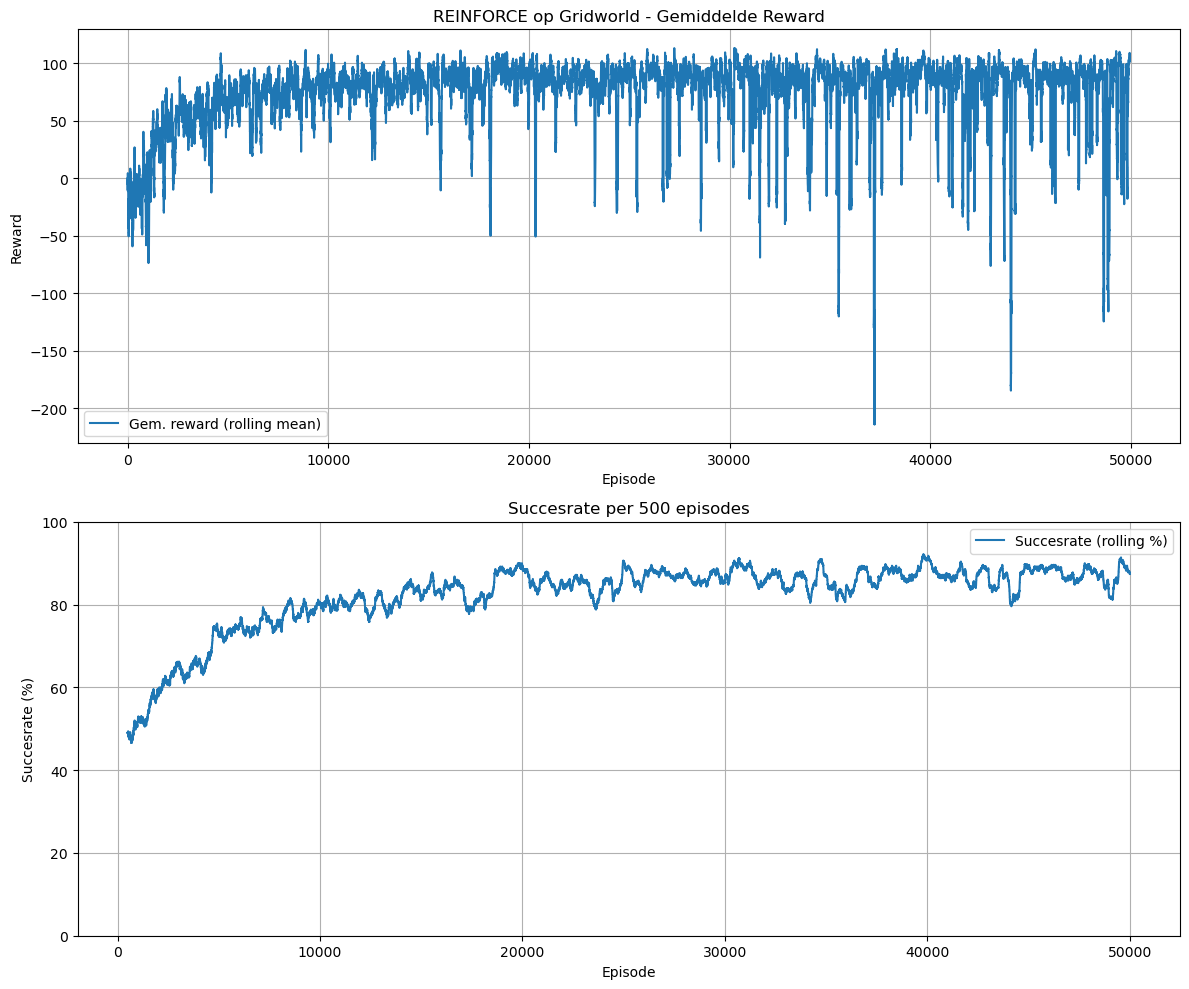

C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_11144\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 1705570x
  Reward 1.5: 680699x
  Reward -5: 149436x
  Reward 100: 41098x
  Reward -50: 8315x

--- Gemiddelde succesrate: 82.20% over 50000 episodes


In [11]:
torch.manual_seed(2025)  # Stel de random seed in voor PyTorch voor reproduceerbaarheid.
np.random.seed(2025)  # Stel de random seed in voor NumPy voor reproduceerbaarheid.

iter5_config = Config(  # Maak een configuratie voor iteratie 5.
    env_size=10,  # Grootte van de Gridworld-omgeving.
    hidden_size=128,  # Aantal neuronen in de verborgen laag van het netwerk.
    lr=0.001,  # Leerpercentage voor de optimizer.
    gamma=0.8,  # Discount factor voor toekomstige beloningen.
    episodes=50000,  # Aantal trainingsepisodes (lange training).
    max_steps=1000  # Maximum aantal stappen per episode.
)

agent, scores, wins, reward_stats = train_agent(  # Train de agent met de opgegeven configuratie.
    iter5_config,  # Configuratie voor de training.
    reward_fn=reward_iter2,  # Beloningsfunctie voor iteratie 2.
    state_fn=state_rendernp  # State-functie gebaseerd op render_np.
)

print("\n--- Test iteratie 5 (50000 episodes) ---")  # Print testinformatie.
test_agent(agent, env_size=10, state_fn=state_rendernp, reward_fn=reward_iter2)  # Test de getrainde agent.

plot_results(scores, wins)  # Visualiseer de resultaten van de training.
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)  # Maak een animatie van het pad van de agent.
display(HTML(ani.to_jshtml()))  # Toon de animatie in Jupyter Notebook.

print("\n--- Reward telling ---")  # Print statistieken over de beloningen.
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):  # Sorteer beloningen op frequentie.
    print(f"  Reward {reward_value}: {count}x")  # Print de beloningswaarde en het aantal keren dat deze voorkwam.

mean_successrate = np.mean(wins) * 100  # Bereken het gemiddelde succespercentage.
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")  # Print het succespercentage.


Gemiddelde reward: De reward-curve laat zien dat de agent zich snel stabiliseert rond een hoge beloning. Er zijn wel incidentele uitschieters naar beneden, wat waarschijnlijk komt door foutieve beslissingen of moeilijkere startsituaties, maar over het algemeen blijft de performance consistent positief.

Succesrate: De rolling succesrate is indrukwekkend gestegen tot boven de 80%. De lijn stabiliseert zich tussen de 80% en 90%, wat aangeeft dat de agent in veruit de meeste gevallen succesvol naar het doel beweegt.

Gemiddelde succesrate: De uiteindelijke succesrate over 50.000 episodes komt uit op 82.20%, waarmee het leerdoel van >80% is behaald.

Reward telling:

De agent bereikt het doel 6315 keer.

Hij valt 4198 keer in de pit.

Er is ook een flinke hoeveelheid beloningen voor exploratiegedrag zoals nieuwe posities (1.5) en herhalingen (-0.2), wat aantoont dat het exploratie-exploitatiegedrag in balans is.

Animatie: De geanimeerde visualisatie bevestigt dat de agent efficiënt en gericht naar het doel beweegt. Hij vermijdt gevaren zoals de pit en bereikt de goal vaak binnen een paar stappen.

Conclusie:
De agent is succesvol getraind met behulp van REINFORCE in combinatie met een aangepaste rewardfunctie en voldoende trainingstijd. Door het verhogen van het aantal episodes naar 50.000 is de agent in staat geweest om zijn beleid te verfijnen tot een betrouwbaar succesniveau. Verdere verbetering is mogelijk, maar de leerdoelstelling van een gemiddelde succesrate boven de 80% is overtuigend gehaald.

In [12]:
def test_model(agent, env_size=10, max_steps=200, state_fn=state_rendernp, reward_fn=reward_iter2, display=True):
    # Maak een nieuwe Gridworld-omgeving met een willekeurige startpositie.
    env = Gridworld(size=env_size, mode='random')
    # Verkrijg de startstaat van de omgeving met behulp van de opgegeven state_fn.
    state = state_fn(env)
    # Initialiseer een set om bezochte posities bij te houden.
    visited = set()
    # Initialiseer de totale beloning op 0.
    total_reward = 0

    if display:
        # Toon de startomgeving als display=True.
        print("Initial state:")
        env.display()

    for step in range(max_steps):
        # Verkrijg actieprobabiliteiten van het beleid van de agent.
        probs = agent.get_policy(state)
        # Kies een actie stochastisch op basis van de actieprobabiliteiten.
        action = np.random.choice(4, p=probs)
        # Sla de oude positie van de speler op.
        old_pos = env.board.components['Player'].pos
        # Voer de gekozen actie uit in de omgeving.
        env.makeMove(agent.action_set[action])
        # Verkrijg de nieuwe positie van de speler.
        new_pos = env.board.components['Player'].pos

        # Bereken de beloning met behulp van de opgegeven beloningsfunctie.
        reward = reward_fn(env, old_pos, new_pos, visited)
        # Voeg de beloning toe aan de totale beloning.
        total_reward += reward
        # Voeg de nieuwe positie toe aan de set van bezochte posities.
        visited.add(new_pos)
        # Update de huidige staat van de omgeving.
        state = state_fn(env)

        if display:
            # Toon informatie over de huidige stap, actie, beloning en de omgeving.
            print(f"Step {step+1} | Action: {agent.action_set[action]} | Reward: {reward:.2f}")
            env.display()

        if new_pos == env.board.components['Goal'].pos:
            # Als de agent het doel bereikt, toon een bericht en retourneer succes.
            if display:
                print(f" Goal reached! Total reward: {total_reward:.2f}")
            return True, total_reward, step+1
        elif new_pos == env.board.components['Pit'].pos:
            # Als de agent in de valkuil valt, toon een bericht en retourneer falen.
            if display:
                print(f" Pit fallen! Total reward: {total_reward:.2f}")
            return False, total_reward, step+1

    if display:
        # Als de agent de maximale stappen bereikt zonder einde, toon een timeout-bericht.
        print(f" Timeout. Total reward: {total_reward:.2f}")
    # Retourneer None (geen succes of falen), de totale beloning en het aantal stappen.
    return None, total_reward, max_steps


## Test
Om te beoordelen of mijn getrainde agent ook generaliseert buiten de trainingsdata, test ik het model op 100 nieuwe, willekeurige GridWorld-omgevingen. Tijdens deze test wordt het model niet verder getraind. Ik evalueer of de agent succesvol het doel bereikt, in een pit valt of vastloopt (timeout). Op basis van deze test meet ik de succesrate, gemiddelde reward en het gemiddeld aantal stappen per episode.



In [13]:
def test_multiple_models(agent, n=100, **kwargs):
    # Initialiseer variabelen om statistieken bij te houden
    wins = 0  # Aantal succesvolle episodes (goal bereikt)
    losses = 0  # Aantal episodes waarin de agent in de valkuil viel
    unfinished = 0  # Aantal episodes die niet zijn voltooid (timeout)
    total_rewards = 0  # Totale beloning over alle episodes
    total_steps = 0  # Totaal aantal stappen over alle episodes

    # Voer n testepisodes uit
    for _ in range(n):
        # Test de agent in een enkele episode zonder de omgeving te tonen
        result = test_model(agent, display=False, **kwargs)
        
        # Controleer de uitkomst van de episode
        if result[0] is None:  # Episode niet voltooid (timeout)
            unfinished += 1
        elif result[0] is False:  # Agent viel in de valkuil
            losses += 1
        elif result[0] is True:  # Agent bereikte het doel
            wins += 1

        # Voeg de beloning en het aantal stappen van deze episode toe aan de totalen
        total_rewards += result[1]  # Beloning van de episode
        total_steps += result[2]  # Aantal stappen in de episode

    # Toon de resultaten van de test
    print(f"\n Resultaten over {n} testepisodes:")
    print(f" Succesrate:      {wins/n * 100:.1f}%")  # Percentage succesvolle episodes
    print(f" Pit deaths:      {losses/n * 100:.1f}%")  # Percentage episodes waarin de agent in de valkuil viel
    print(f" Timeouts:         {unfinished/n * 100:.1f}%")  # Percentage episodes die niet zijn voltooid
    print(f" Gem. reward:      {total_rewards/n:.2f}")  # Gemiddelde beloning per episode
    print(f" Gem. episode len: {total_steps/n:.1f}")  # Gemiddeld aantal stappen per episode


In [14]:
test_multiple_models(agent, n=100, env_size=10, max_steps=1000, state_fn=state_rendernp, reward_fn=reward_iter2)




 Resultaten over 100 testepisodes:
 Succesrate:      84.0%
 Pit deaths:      15.0%
 Timeouts:         1.0%
 Gem. reward:      35.31
 Gem. episode len: 25.8


Na iteratie 5 heb ik het uiteindelijke model getest in 100 willekeurige episodes. De agent behaalde een succesrate van 84%, wat hoger is dan mijn streefdoel van 80%. Dit bevestigt dat het model niet alleen binnen de trainingsdata goed presteert, maar ook generaliseert naar nieuwe situaties. Daarom zijn verdere iteraties of aanpassingen niet nodig.